In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

# path to images
path = 'data/'
categories = ['debris', 'forest', 'water']

2023-02-04 20:40:43.046680: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


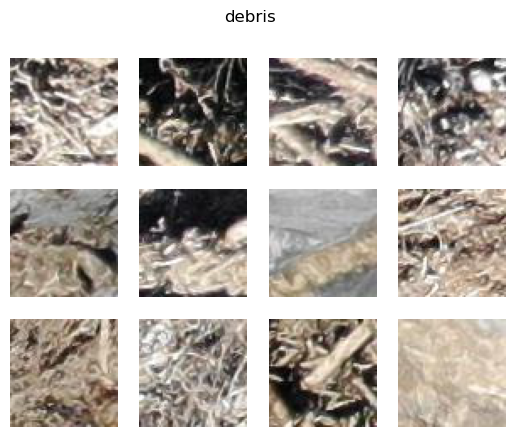

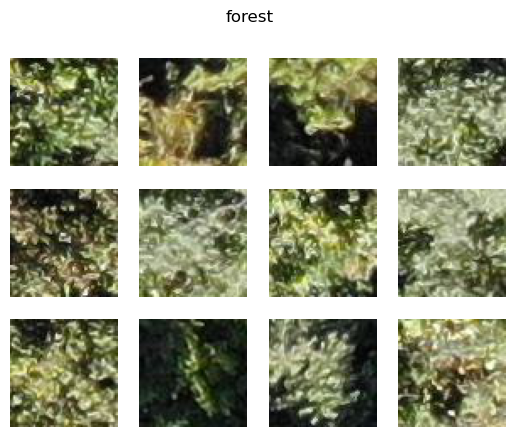

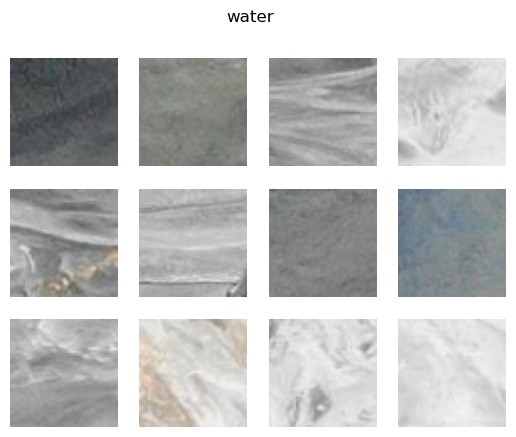

In [2]:
for category in categories:
    fig, _ = plt.subplots(3,4)
    fig.suptitle(category)
    #fig.patch.set_facecolor('xkcd:white')
    for k, v in enumerate(os.listdir(path+category)[:12]):
        img = plt.imread(path+category+'/'+v)
        plt.subplot(3, 4, k+1)
        plt.axis('off')
        plt.imshow(img)
    plt.show()

In [3]:
shape0 = []
shape1 = []

for category in categories:
    for files in os.listdir(path+category):
        #try:
            shape0.append(plt.imread(path+category+'/'+ files).shape[0])
            shape1.append(plt.imread(path+category+'/'+ files).shape[1])
        #except UnidentifiedImageError:
            #pass
    print(category, ' => height min : ', min(shape0), 'width min : ', min(shape1))
    print(category, ' => height max : ', max(shape0), 'width max : ', max(shape1))
    shape0 = []
    shape1 = []

debris  => height min :  64 width min :  64
debris  => height max :  64 width max :  64
forest  => height min :  64 width min :  64
forest  => height max :  64 width max :  64
water  => height min :  64 width min :  64
water  => height max :  64 width max :  64


In [4]:
data = []
labels = []
imagePaths = []
HEIGHT = 64
WIDTH = 64
N_CHANNELS = 3

for k, category in enumerate(categories):
    for f in os.listdir(path+category):
        imagePaths.append([path+category+'/'+f, k]) # k=0 : 'debris', k=1 : 'forest', k=2 : 'water'

import random
random.shuffle(imagePaths)
print(imagePaths[:10])

for imagePath in imagePaths:
    image = cv2.imread(imagePath[0])
    image = cv2.resize(image, (WIDTH, HEIGHT))  # .flatten()
    data.append(image)
    label = imagePath[1]
    labels.append(label)

[['data/water/DJI_0682_1920_2112.JPG', 2], ['data/water/DJI_0682_576_1280.JPG', 2], ['data/water/DJI_0682_1920_3648.JPG', 2], ['data/water/DJI_0682_832_3200.JPG', 2], ['data/water/DJI_0682_384_2048.JPG', 2], ['data/debris/DJI_0684_1728_2240.JPG', 0], ['data/water/DJI_0682_128_1920.JPG', 2], ['data/water/DJI_0682_320_1792.JPG', 2], ['data/water/DJI_0682_128_960.JPG', 2], ['data/debris/DJI_0684_0_1216.JPG', 0]]


In [5]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

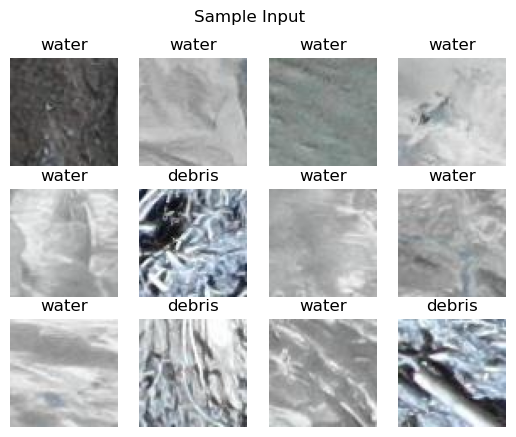

In [6]:
fig, _ = plt.subplots(3,4)
fig.suptitle("Sample Input")
fig.patch.set_facecolor('xkcd:white')
for i in range(12):
    plt.subplot(3,4, i+1)
    plt.imshow(data[i])
    plt.axis('off')
    plt.title(categories[labels[i]])
plt.show()

In [7]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)

In [8]:
trainY = np_utils.to_categorical(trainY, 3)

print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(2019, 64, 64, 3)
(505, 64, 64, 3)
(2019, 3)
(505,)


In [9]:
model = Sequential()

model.add(Convolution2D(32, (2, 2), activation='relu', input_shape=(HEIGHT, WIDTH, N_CHANNELS)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


2023-02-04 20:41:40.426398: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 conv2d (Conv2D)             (None, 63, 63, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dense (Dense)               (None, 128)               921728    
          

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

In [12]:
hist = model.fit(trainX, trainY, batch_size=32, epochs=25, verbose=1,callbacks=[checkpoint,early])

Epoch 1/25
64/64 [==============================] - 15s 198ms/step - loss: 0.6110 - accuracy: 0.7355
Epoch 2/25
33/64 [==============>...............] - ETA: 6s - loss: 0.1967 - accuracy: 0.9356WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


64/64 [==============================] - 12s 189ms/step - loss: 0.1624 - accuracy: 0.9490
Epoch 3/25
64/64 [==============================] - 11s 178ms/step - loss: 0.1048 - accuracy: 0.9703
Epoch 4/25
 1/64 [..............................] - ETA: 11s - loss: 0.0782 - accuracy: 0.9688WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


51/64 [======================>.......] - ETA: 2s - loss: 0.1439 - accuracy: 0.9449WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


64/64 [==============================] - 12s 188ms/step - loss: 0.1308 - accuracy: 0.9500
Epoch 5/25
64/64 [==============================] - 13s 211ms/step - loss: 0.0705 - accuracy: 0.9777
Epoch 6/25
20/64 [========>.....................] - ETA: 8s - loss: 0.0545 - accuracy: 0.9844WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


64/64 [==============================] - 11s 170ms/step - loss: 0.0605 - accuracy: 0.9812
Epoch 7/25
 5/64 [=>............................] - ETA: 8s - loss: 0.0477 - accuracy: 0.9875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


55/64 [========================>.....] - ETA: 1s - loss: 0.0617 - accuracy: 0.9795WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


64/64 [==============================] - 12s 183ms/step - loss: 0.0599 - accuracy: 0.9807
Epoch 8/25
64/64 [==============================] - 11s 165ms/step - loss: 0.0316 - accuracy: 0.9916
Epoch 9/25
23/64 [=========>....................] - ETA: 6s - loss: 0.0832 - accuracy: 0.9769WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


64/64 [==============================] - 10s 152ms/step - loss: 0.0518 - accuracy: 0.9851
Epoch 10/25
 8/64 [==>...........................] - ETA: 9s - loss: 0.0265 - accuracy: 0.9922WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


58/64 [==========================>...] - ETA: 0s - loss: 0.0255 - accuracy: 0.9930WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


64/64 [==============================] - 10s 155ms/step - loss: 0.0245 - accuracy: 0.9936
Epoch 11/25
64/64 [==============================] - 12s 184ms/step - loss: 0.0525 - accuracy: 0.9837
Epoch 12/25
27/64 [===========>..................] - ETA: 6s - loss: 0.0400 - accuracy: 0.9861WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


64/64 [==============================] - 11s 176ms/step - loss: 0.0483 - accuracy: 0.9856
Epoch 13/25
61/64 [===========================>..] - ETA: 0s - loss: 0.0236 - accuracy: 0.9939WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


64/64 [==============================] - 12s 194ms/step - loss: 0.0232 - accuracy: 0.9941
Epoch 14/25
46/64 [====================>.........] - ETA: 3s - loss: 0.0198 - accuracy: 0.9932WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


64/64 [==============================] - 11s 177ms/step - loss: 0.0226 - accuracy: 0.9936
Epoch 15/25
31/64 [=============>................] - ETA: 6s - loss: 0.0274 - accuracy: 0.9940WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


64/64 [==============================] - 12s 191ms/step - loss: 0.0204 - accuracy: 0.9946
Epoch 16/25
64/64 [==============================] - 13s 199ms/step - loss: 0.0143 - accuracy: 0.9950


Epoch 17/25
64/64 [==============================] - 11s 172ms/step - loss: 0.0201 - accuracy: 0.9921
Epoch 18/25
33/64 [==============>...............] - ETA: 6s - loss: 0.0232 - accuracy: 0.9905WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


64/64 [==============================] - 13s 200ms/step - loss: 0.0358 - accuracy: 0.9861
Epoch 19/25
64/64 [==============================] - 10s 159ms/step - loss: 0.0225 - accuracy: 0.9946
Epoch 20/25
 1/64 [..............................] - ETA: 10s - loss: 0.1057 - accuracy: 0.9688WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


51/64 [======================>.......] - ETA: 2s - loss: 0.0666 - accuracy: 0.9798WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


64/64 [==============================] - 10s 150ms/step - loss: 0.0580 - accuracy: 0.9817
Epoch 21/25
36/64 [===============>..............] - ETA: 4s - loss: 0.0185 - accuracy: 0.9948WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


64/64 [==============================] - 10s 152ms/step - loss: 0.0189 - accuracy: 0.9946
Epoch 22/25
21/64 [========>.....................] - ETA: 6s - loss: 0.0207 - accuracy: 0.9955WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


64/64 [==============================] - 10s 163ms/step - loss: 0.0309 - accuracy: 0.9901
Epoch 23/25
55/64 [========================>.....] - ETA: 1s - loss: 0.0173 - accuracy: 0.9960WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


64/64 [==============================] - 11s 164ms/step - loss: 0.0165 - accuracy: 0.9965
Epoch 24/25
40/64 [=================>............] - ETA: 3s - loss: 0.0083 - accuracy: 0.9977WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


64/64 [==============================] - 10s 154ms/step - loss: 0.0153 - accuracy: 0.9960
Epoch 25/25
25/64 [==========>...................] - ETA: 6s - loss: 0.0211 - accuracy: 0.9925WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


64/64 [==============================] - 10s 161ms/step - loss: 0.0483 - accuracy: 0.9827


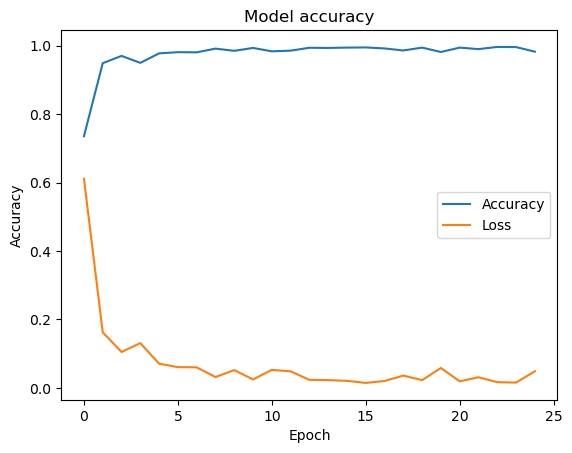

In [16]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
#plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
#plt.plot(hist.history['val_loss'])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Loss"])
plt.show()

In [1]:
from numpy import argmax
from sklearn.metrics import confusion_matrix, accuracy_score

pred = model.predict(testX)
predictions = argmax(pred, axis=1)

cm = confusion_matrix(testY, predictions)

fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Model confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + categories)
ax.set_yticklabels([''] + categories)

for i in range(3):
    for j in range(3):
        ax.text(i, j, cm[j, i], va='center', ha='center')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


accuracy = accuracy_score(testY, predictions)
print("Accuracy : %.2f%%" % (accuracy*100.0))

NameError: name 'model' is not defined

1/1 [==============================] - 0s 81ms/step
Prediction : forest


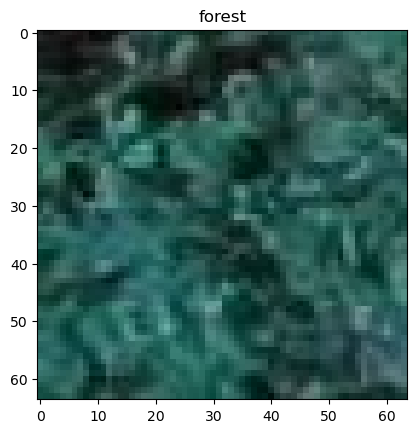

In [18]:
test_data=[]
test_image_o = cv2.imread('/Users/mac/Library/CloudStorage/OneDrive-TUM/masters/1 sem/Selected topics/BBKI_drone_debris_detection/DJI_0682_128_256.JPG')
test_image = cv2.resize(test_image_o, (WIDTH, HEIGHT))
test_data.append(test_image)

test_data = np.array(test_image, dtype="float") / 255.0
test_data=test_data.reshape([-1,64, 64, 3])
pred = model.predict(test_data)
predictions = argmax(pred, axis=1)
print ('Prediction : '+categories[predictions[0]])

fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
plt.title(categories[predictions[0]])
plt.imshow(test_image_o)

1/1 [==============================] - 0s 41ms/step
Prediction : water


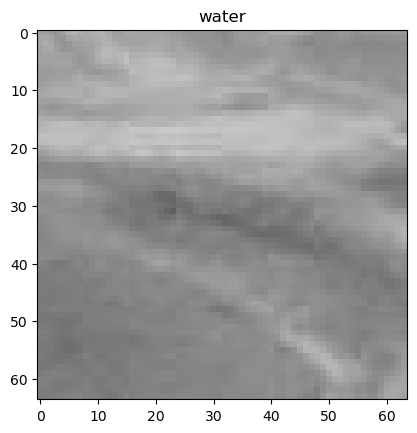

In [19]:
test_data=[]
test_image_o = cv2.imread('/Users/mac/Library/CloudStorage/OneDrive-TUM/masters/1 sem/Selected topics/BBKI_drone_debris_detection/DJI_0682_0_768.JPG')
test_image = cv2.resize(test_image_o, (WIDTH, HEIGHT))
test_data.append(test_image)

test_data = np.array(test_image, dtype="float") / 255.0
test_data=test_data.reshape([-1,64, 64, 3])
pred = model.predict(test_data)
predictions = argmax(pred, axis=1)
print ('Prediction : '+categories[predictions[0]])

fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
plt.title(categories[predictions[0]])
plt.imshow(test_image_o)

In [20]:
model.save_weights('model_weights.h5')

In [21]:
model.save('/Users/mac/Library/CloudStorage/OneDrive-TUM/masters/1 sem/Selected topics/BBKI_drone_debris_detection/attempt 6')

INFO:tensorflow:Assets written to: /Users/mac/Library/CloudStorage/OneDrive-TUM/masters/1 sem/Selected topics/BBKI_drone_debris_detection/attempt 6/assets


INFO:tensorflow:Assets written to: /Users/mac/Library/CloudStorage/OneDrive-TUM/masters/1 sem/Selected topics/BBKI_drone_debris_detection/attempt 6/assets
